In [ ]:
# Veri Madenciliği Final Ödevi
# 173322046 Eren Talha Temur
"Veri Seti : https://www.kaggle.com/datasets/milanvaddoriya/data-science-job-salary"
"Seçtiğim Data Science Job Salary veri seti, güncel iş dünyasının en dinamik ve bizleri en çok ilgilendiren" 
"veri bilimi alanındaki gelir dağılımını anlamak için tasarlanmıştır."
"Bu veriseti 2020 ile 2023 yılları arasındaki küresel maaş verilerini içermektedir ve iş unvanları,deneyim seviyeleri,"
"çalışılan şirketin büyüklüğü ve çalışma şekli faktörlerle ilişkili olduğundan"
"regresyona uygundur."

#Veri setindeki temel değişkenler
#Experience_level: Çalışanın deneyim düzeyi
#Employment_type: İstihdam türü
#job_title: Pozisyon adı (Veri Bilimci, ML Mühendisi, Veri Analisti vb.).
#salary_in_usd: Bağımlı değişken.Maaşın Amerikan Doları cinsinden karşılığı.
#remote_ratio: Uzaktan çalışma oranı.
#company_size: Şirketin büyüklüğü (Küçük, Orta, Büyük).


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from warnings import filterwarnings
filterwarnings('ignore')

In [63]:
#Verinin içe aktarılması ve ilk 10 gözlemin kontrol amaçlı görüntülenmesi
data= pd.read_csv("/Users/eren.temur/Desktop/DERSLER İÇİN NOTLAR/VERİ MADENCİLİĞİ/FİNAL ÖDEV/datascience_salaries.csv")
data.head(10)

,Unnamed: 0,job_title,job_type,experience_level,location,salary_currency,salary
0,0,Data scientist,Full Time,Senior,New York City,USD,149000
1,2,Data scientist,Full Time,Senior,Boston,USD,120000
2,3,Data scientist,Full Time,Senior,London,USD,68000
3,4,Data scientist,Full Time,Senior,Boston,USD,120000
4,5,Data scientist,Full Time,Senior,New York City,USD,149000
5,6,Data scientist,Full Time,Senior,London,USD,68000
6,7,Data scientist,Full Time,Senior,Research Triangle Park,USD,69000
7,8,Data scientist,Full Time,Senior,Sydney,USD,68000
8,9,Data scientist,Full Time,Senior,San Francisco,USD,140000
9,10,Data scientist,Full Time,Senior,Sofia,USD,68000


In [64]:
#Veri ön işleme adımları
print(data.info())
# Yorum: İlk sırada bulunan Unnamed adlı değişken index sütunu olduğundan, bu sütun veriden atılmalıdır.
# Hedef değişken olan salary değişkeninde üç para biriminden maaş bulunuyor fakat verinin %98'i USD biriminde olduğundan
# GBP ve EUR ile etiketlenen 14 ölçüm veriden temizlenmiştir.

# Verideki 5 sütun metin tipindedir modellerin çalışabilmesi adına bunları sayısal verilere dönüştürmemiz gerekir.
print(f"VERİ TEMİZLEME ADIMI")
data = data[data['salary_currency'] == 'USD'].copy()
data.drop(['salary_currency', 'Unnamed: 0'], axis=1, inplace=True)
print(f"Gereksiz sütundan ve USD harici birimlerden temizlenen data")
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1171 non-null   int64 
 1   job_title         1171 non-null   object
 2   job_type          1171 non-null   object
 3   experience_level  1171 non-null   object
 4   location          1171 non-null   object
 5   salary_currency   1171 non-null   object
 6   salary            1171 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 64.2+ KB
None
VERİ TEMİZLEME ADIMI
Gereksiz sütundan ve USD harici birimlerden temizlenen data


,job_title,job_type,experience_level,location,salary
0,Data scientist,Full Time,Senior,New York City,149000
1,Data scientist,Full Time,Senior,Boston,120000
2,Data scientist,Full Time,Senior,London,68000
3,Data scientist,Full Time,Senior,Boston,120000
4,Data scientist,Full Time,Senior,New York City,149000


In [65]:
#Eksik veri kontrolü
print(data.isnull().sum())
#Veride bulunan değişkenlerin hiçbirinde eksik gözlem bulunmamaktadır.

job_title           0
job_type            0
experience_level    0
location            0
salary              0
dtype: int64


Bağımlı değişkenin kutu grafiği ile görselleştirilmesi


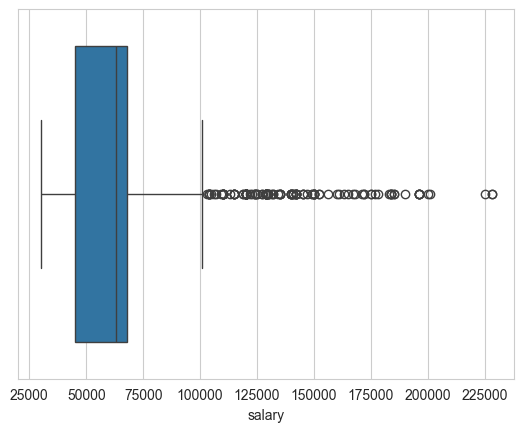

Alt Sınır: 10500.0
Üst Sınır: 102500.0
Tespit edilen aykırı gözlem sayısı: 139


In [66]:
#Bağımlı değişken olarak kullanacağımız "salary" değişkenini görselleştirelim.
#Ardından bu veri için aykırı değer tespiti yapalım.
print("Bağımlı değişkenin kutu grafiği ile görselleştirilmesi")
sbn.boxplot(x=data["salary"])
plt.show()

#Alt sınırdan küçük aykırı değer görünmemektedir. Fakat üst sınırdan büyük hayli fazla aykırı değer bulunuyor. 
#IQR yöntemi ile aykırı değerleri belirleyip index no'ları ve toplam sayısına bakalım.
Q1 = data['salary'].quantile(0.25)
Q3 = data['salary'].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

print(f"Alt Sınır: {alt_sinir}")
print(f"Üst Sınır: {ust_sinir}")

aykiri_veriler = data[(data['salary'] < alt_sinir) | (data['salary'] > ust_sinir)]
print(f"Tespit edilen aykırı gözlem sayısı: {len(aykiri_veriler)}")


In [67]:
#Object tipinde bulunan veriler olan 'job_title', 'job_type', 'experience_level', 'location' 
#değişkenleri için dummy variables oluşturuyoruz.
finaldata= pd.get_dummies(data, columns=['job_title', 'job_type', 'experience_level', 'location'], drop_first=True)
finaldata.head(10)
#Drop first argümanı da kullanılarak tüm object tipindeki değişkenleri regresyon modeline uygun hale getirdik. Artık bu değişkenlerle
#birlikte daha doğru maaş tahminleri yapabileceğiz.

,salary,job_title_Data analyst,job_title_Data scientist,job_title_ML Ops,job_title_Machine learning,job_type_Internship,experience_level_Executive,experience_level_Mid,experience_level_Senior,location_Aberdeen,...,location_West Point,location_Westminster,location_Wien,location_Wilmington,location_Work from Home,location_Wrocław,location_Zurich,location_tel aviv,location_České Budějovice,location_İstanbul
0,149000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,120000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,68000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,120000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,149000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5,68000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
6,69000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,68000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8,140000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9,68000,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
#Bağımlı - Bağımsız değişken ayrımının yapılması
y=finaldata["salary"]
x=finaldata.drop("salary",axis=1)
print(f"x boyutu:", x.shape)
print(f"y boyutu:", y.shape)
#Eğitim - Test Ayrışımı
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=34)
#Train test ayrışımı başarıyla tamamlandı.

x boyutu: (1157, 325)
y boyutu: (1157,)


In [69]:
#Veride maaş değişkeni binlerce birim iken, dummy değişkenler 0 ve 1'lerden oluşmaktadır.Tüm özellikleri aynı ölçeğe çekmeliyiz.
scaler=StandardScaler()
x_train_sc=scaler.fit_transform(x_train)
x_test_sc=scaler.transform(x_test)
#MLP KISMINA GEÇİLİRKEN EKLENDİ.
scaler_y = StandardScaler()
y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [70]:
#1.Lineer Regresyon adımı
#Model çerçevesi ve modelin fit edilmesi
lm=LinearRegression()
lrmodel=lm.fit(x_train,y_train)
print(f"Modelin sabit katsayısı:",lrmodel.intercept_)
katsayilar = pd.DataFrame(lm.coef_, x.columns)
print(f"Modelin beta katsayılarının ilk 5'i:",katsayilar.head(5))
#Model yorumu: Sabit katsayı olan 32.323; modeldeki tüm değişkenler sıfır olduğundaki maaş yani başlangıç maaşıdır.
#En yüksek pozitif etkiye sahip unvan ML OPS'tur.Bu uzmanlığın maaşı ciddi şekilde arttırdığını gösterir.
#Internship unvanı beklendiği gibi negatif etkiye sahiptir.Stajyer pozisyonları baz maaşı 8500 dolar aşağı çeker.
#Data analyst & Scientist ise maaşa pozitif katkı sağlıyor.

# Deneyim seviyelerine göre maaş yorumları:
deneyim_katsayilari = katsayilar[katsayilar.index.str.contains("experience_level_")]
print(f"Deneyim Seviyelerinin Maaş Üzerindeki Etkisi:",deneyim_katsayilari)
# Executive pozisyonundaki bir kişi giriş seviyesindeki birine göre 35 bin dolar daha fazla maaş almaktadır.
# Senior çalışanların maaşa etkisi Executive etkisine çok yakın, teknik uzmanlığın sektörde dikkate alındığı görünüyor.
# Mid seviye çalışanlar giriş seviyesinden 11.400 dolar daha fazla kazanıyor.

Modelin sabit katsayısı: 32323.053689696426
Modelin beta katsayılarının ilk 5'i:                                        0
job_title_Data analyst       6798.913479
job_title_Data scientist     5798.045739
job_title_ML Ops            12789.007858
job_title_Machine learning   3864.458865
job_type_Internship         -8540.576718
Deneyim Seviyelerinin Maaş Üzerindeki Etkisi:                                        0
experience_level_Executive  34964.430073
experience_level_Mid        11431.968135
experience_level_Senior     32456.111442


In [71]:
#Model performansının değerlendirilmesi
#Eğitim seti tahminleri
y_train_pred = lrmodel.predict(x_train_sc)
#Test seti tahminleri
y_test_pred = lrmodel.predict(x_test_sc)

#Metriklerin hesaplanması
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Eğitim seti sonuçları:")
print(f"RMSE",rmse_train)
print(f"R2",r2_train)

print(f"Test seti sonuçları:")
print(f"RMSE",rmse_test)
print(f"R2",r2_test)
#Eğitim ve test setinin bu kadar kötü sonuçlar vermesinin sebebi bağımsız değişken sayımızın çok fazla olması
#Bu sorunu aşmak için Lasso ve Ridge yöntemlerini kullanarak modeli düzenlemeye çalışacağım.

Eğitim seti sonuçları:
RMSE 375520.8929261207
R2 -128.69532010865788
Test seti sonuçları:
RMSE 331595.4366946137
R2 -111.02144518339004


In [72]:
#LASSO MODEL
lassomodel=Lasso(max_iter=10000,alpha=100).fit(x_train_sc,y_train)
y_pred_lasso = lassomodel.predict(x_test_sc)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Model Metrikleri:",f"R2:",r2_lasso,f"RMSE:",rmse_lasso)
#Lasso sayesinde modelimiz devasa hatadan kurtularak mantıklı tahminler yapmaya başladı.
#Maaşlardaki değişimin yaklaşık %49'u sadece unvan,lokasyon ve deneyim ile açıklayabiliyoruz.
#Tahminlerimiz gerçek maaşlardan ort. 22bin dolar sapmaktadır.

#RIDGE MODEL:En iyi alfa parametresi ile model tunning yapacağız.
from sklearn.linear_model import Ridge, RidgeCV
alphalar = 10**np.linspace(10, -2, 100) * 0.5
ridge_cv = RidgeCV(alphas=alphalar, scoring="neg_mean_squared_error").fit(x_train_sc, y_train)
print(f"En iyi alfa parametresi:",ridge_cv.alpha_)
ridgemodel = Ridge(alpha=ridge_cv.alpha_).fit(x_train_sc, y_train)
#Metriklerin hesaplanması
y_pred_ridge = ridgemodel.predict(x_test_sc)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Performans Metrikleri:",f"R2:",r2_ridge,f"RMSE:",rmse_ridge)

#Özet: Lasso model Ridge Modelden daha iyi performans göstermektedir bunun sebebi de Lassonun gereksiz gürültü oluşturan değişkenleri sıfıra eşitleuerek elemesidir.

Lasso Model Metrikleri: R2: 0.4876197029652696 RMSE: 22426.1214760729
En iyi alfa parametresi: 0.005
Performans Metrikleri: R2: 0.48695528904395413 RMSE: 22440.656968722178


In [73]:
#ElasticNet uygulaması
from sklearn.linear_model import ElasticNet, ElasticNetCV
enet_cv_model = ElasticNetCV(alphas=None, l1_ratio=[.1, .5, .7, .9, .95, .99, 1],cv=10, max_iter=10000).fit(x_train_sc, y_train)

print(f"En iyi Alpha: {enet_cv_model.alpha_}")
print(f"En iyi L1 Oranı (l1_ratio): {enet_cv_model.l1_ratio_}")
#L1 RATIO DEĞERİ 1 OLDUĞUNDAN ELASTIC NET SONUCLARI LASSO İLE AYNI OLACAKTIR.
#NİHAİ MODEL LASSODUR.


En iyi Alpha: 206.42501572904797
En iyi L1 Oranı (l1_ratio): 1.0


In [74]:
#KNN YÖNTEMİ
from sklearn.neighbors import KNeighborsRegressor
# Model Oluştruma
KNN = KNeighborsRegressor().fit(x_train_sc, y_train)
#Tahminler
y_pred=KNN.predict(x_test_sc)
#Performans Metrikleri:
rmse_KNN=np.sqrt(mean_squared_error(y_test, y_pred))
r2_KNN=r2_score(y_test, y_pred)
print(f"Komşuluk sayısı 5 iken RMSE:",rmse_KNN,f"Komşuluk sayısı 5 iken R2:",r2_KNN)
#Varsayılan komşuluk sayısı kullanıldığında KNN model Lassonun verdiği skorun gerisinde kaldı.
#Veri setindeki maaşlar ile özellikler arasındaki ilişki komşuluk ilişkisindense doğrusal ilişki gösteriyorlar.
#Bu sebepten, Lasso model daha başarılıdır.

#Model Tuning ile KNN iyileştirme
#Gridsearch tarafından denenecek komşuluk sayıları belirlendi.
knn_params = {"n_neighbors": np.arange(1, 31, 1)}
#Modeli çalıştırma
knn = KNeighborsRegressor()
knn_cv_model = GridSearchCV(knn, knn_params, cv=10).fit(x_train_sc, y_train)

#En iyi komşuluk değeri
bestkomsu=knn_cv_model.best_params_["n_neighbors"]
print(f"KNN için en iyi komşu sayısı:",bestkomsu)
#En iyi komşu değeri 13 çıktı, bu değer ile modelimizi tekrar kuralım.
tunedknn=KNeighborsRegressor(n_neighbors=bestkomsu).fit(x_train_sc, y_train)
tunedpred=tunedknn.predict(x_test_sc)
#TUNING YAPILMIŞ MODELDE TEKRAR PERFORMANS INCELEYELİM
tunedrmse=np.sqrt(mean_squared_error(y_test, tunedpred))
tunedr2=r2_score(y_test, tunedpred)
print(f"Komşuluk sayısı 13 iken RMSE:",tunedrmse,f"Komşuluk sayısı 13 iken R2:",tunedr2)

#YORUM:Yapılan model tuning sonucunda en iyi komşu sayısını 13 olarak belirledik ve R2 değerini
#0.28'den 0.32 'ye yükselmiştir.Ancak bu skor yine de Lasso modelin gerisinde kalmıştır.Veride mesafeden ziyade doğrusal bir eğilim vardır.

Komşuluk sayısı 5 iken RMSE: 26556.835602936193 Komşuluk sayısı 5 iken R2: 0.2814835245997397
KNN için en iyi komşu sayısı: 13
Komşuluk sayısı 13 iken RMSE: 25775.743466182346 Komşuluk sayısı 13 iken R2: 0.323128104429266


In [75]:
#SUPPORT VECTOR MACHINES REGRESYONU
from sklearn.svm import SVR
#Doğrusal kernel ile model kurulumu
svrmodel=SVR(kernel="linear").fit(x_train_sc,y_train)
#Tahminlerin alınması ve Performansın değerlendirilmesi
svrpred = svrmodel.predict(x_test_sc)
svrrmse = np.sqrt(mean_squared_error(y_test, svrpred))
svrr2 = r2_score(y_test, svrpred)

print(f"Lineer SVR Modelinde RMSE:",svrrmse,f"Lineer SVR Modelinde R2:",svrr2)

#SVR modelinde R2'nin bu kadar düşük çıkmasının sebebi maaş verimizdeki varyans çok yüksek olduğu için bu kadar düşük performans göstermiştir.
#SVR'nin asıl gücünü RBF yöntemiyle ve doğru parametre seçimiyle görebiliriz.

#Model çerçevesinin oluşturulması
rbfsvr=SVR(kernel="rbf")
#Denenecek parametrelerin belirlenmesi
svrparams = {"C": [0.1, 1, 10, 100, 1000],"epsilon": [0.1, 0.01, 0.2]}
#MODEL TUNING
svr_cv_model = GridSearchCV(rbfsvr, svrparams, cv=5).fit(x_train_sc, y_train)
print(f"En iyi parametreler:",svr_cv_model.best_params_)

#TUNING UYGULANMIŞ MODELIN KURULMASI
tunedsvr = SVR(kernel="rbf",C=svr_cv_model.best_params_["C"],epsilon=svr_cv_model.best_params_["epsilon"]).fit(x_train_sc, y_train)
svrpred = tunedsvr.predict(x_test_sc)
svrrmset = np.sqrt(mean_squared_error(y_test, svrpred))
svrr2t = r2_score(y_test, svrpred)

print(f"Tuning sonrası SVR modelin performansı:",f"RMSE:",svrrmset,f"R2",svrr2t)
#Maaş tahmini gibi gürültülü ve çok boyutlu bir veride SVR gibi karmaşık modeller yerine LASSO model daha iyi performans gösteriyor.
#Çünkü LASSO model değişken seçimi yapar.


Lineer SVR Modelinde RMSE: 31091.779566108973 Lineer SVR Modelinde R2: 0.015138318297578723
En iyi parametreler: {'C': 1000, 'epsilon': 0.01}
Tuning sonrası SVR modelin performansı: RMSE: 30408.72335161799 R2 0.05793589655349529


In [76]:
#KARAR AĞAÇLARI REGRESYONU
from sklearn.tree import DecisionTreeRegressor
#Modelin kurulması
cart_model = DecisionTreeRegressor(random_state=34)
cart_model.fit(x_train, y_train)
#Tahminlerin alınıp metriklerin hesaplanması
cartpred = cart_model.predict(x_test)

#Metrikler
rmse_cart = np.sqrt(mean_squared_error(y_test, cartpred))
r2_cart = r2_score(y_test, cartpred)
print(f"Başlangıç CART modelin performansı:",f"RMSE:",rmse_cart,f"R2",r2_cart)
#Başlangıç CART modelin performansı KNN'den iyidir fakat LASSO'dan kötü durumdadır.
#Şimdi CART modele tuning uygulaması yapıp performansı iyileştirmeye çalışalım.

#TUNING:
cart_params = {"max_depth": [2, 5, 8, 10, 20],"min_samples_split": [2, 5, 10, 20, 50]}
cart = DecisionTreeRegressor(random_state=34)
cart_cv_model = GridSearchCV(cart, cart_params, cv=10).fit(x_train, y_train)
print(f"En iyi derinlik:",cart_cv_model.best_params_['max_depth'],f"En iyi bölünme değeri",cart_cv_model.best_params_['min_samples_split'])

#NIHAI MODELIN KURULMASI VE DEĞERLENDİRİLMESİ
tunedcart = DecisionTreeRegressor(
    max_depth=cart_cv_model.best_params_['max_depth'],
    min_samples_split=cart_cv_model.best_params_['min_samples_split'],
    random_state=34
).fit(x_train, y_train)

#PERFORMANS METRİKLERİNİN HESAPLANMASI
tunedcartpred = tunedcart.predict(x_test)
tuncartrmse = np.sqrt(mean_squared_error(y_test, tunedcartpred))
tuncartr2 = r2_score(y_test, tunedcartpred)
print(f"TUNING uygulanmış CART modelin performansı:",f"RMSE:",tuncartrmse,f"R2",tuncartr2)

#YORUM:Çok önemli bir adımı geçmiş olduk. Lasso modelin performansını geçen ilk model tuning uygulanmış karar ağaçları
#modeli olmuş oldu. Maaş verisindeki değişkenliğin yarısını açıklamayı başardık.
#Veri setindeki özellikler arası ilişki sadece düz bir ilişki ile değil VE'ler ile ifade edilen karar kurallarıyla daha iyi açıklanıyor.
#RMSE'de 300 dolarlık bir düşüş yakaladık Lasso modele göre.

#MAAŞIN BELİRLENMESİNDE EN ÖNEMLİ 10 DEĞİŞKEN NEDİR ?
onemduzeyi = pd.DataFrame({'feature': x.columns, 'importance': tunedcart.feature_importances_})
onemduzeyi = onemduzeyi.sort_values('importance', ascending=False).head(10)
print(f"En önemli 10 değişken:",onemduzeyi)
#Rapor sonunda bu değişkenlerin önemi yorumlanacaktır.

Başlangıç CART modelin performansı: RMSE: 26210.68477485169 R2 0.3000922292073326
En iyi derinlik: 20 En iyi bölünme değeri 50
TUNING uygulanmış CART modelin performansı: RMSE: 22129.68174237368 R2 0.5010759754309421
En önemli 10 değişken:                                    feature  importance
7                  experience_level_Senior    0.257235
253                 location_San Francisco    0.135634
50                       location_Brooklyn    0.084622
240                    location_Remote- US    0.053118
186                 location_New York City    0.036619
294                     location_US Remote    0.031709
189  location_New York City; San Francisco    0.031402
41                         location_Boston    0.028479
239    location_Remote or San Francisco HQ    0.024072
6                     experience_level_Mid    0.023127


In [77]:
#RANDOM FOREST REGRESYONU
from sklearn.ensemble import RandomForestRegressor
#Başlangıç modeli sade bir şekilde kuralım.
rf_model = RandomForestRegressor(random_state=34)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

#METRİKLERİN HESAPLANMASI
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Varsayılan model metrikleri:",f"RMSE:",rmse_rf,f"R2:",r2_rf)

#MODEL TUNING UYGULAMASI:Bunun sonucunda CART modelden daha iyi sonuç vermesini bekleriz.
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_features': [5,10,15],
    'max_depth': [10, 20, 30],
    "min_samples_split":[2,5,10]
}
rf_cv_model = GridSearchCV(RandomForestRegressor(random_state=34),rf_params, 
                           cv=5,n_jobs=-1).fit(x_train, y_train)
print(f"En iyi parametreler:",rf_cv_model.best_params_)

#NIHAI TUNING YAPILMIŞ MODEL
tunedrf = RandomForestRegressor(
    n_estimators=rf_cv_model.best_params_['n_estimators'],
    max_features=rf_cv_model.best_params_['max_features'],
    max_depth=rf_cv_model.best_params_['max_depth'],
    min_samples_split=rf_cv_model.best_params_['min_samples_split'],
    random_state=34
).fit(x_train, y_train)

#SON MODELIN METRIKLERI VE KARŞILAŞTIRMA YORUMU:
y_pred_rf_tuned = tunedrf.predict(x_test)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"TUNED RANDOM FOREST METRİKLERİ:",f"RMSE:",rmse_rf_tuned,f"R2:",r2_rf_tuned)

#YORUM:
#Tuning işlemi varsayılan modelin R2 değerini 0.41'den 0.44'e taşımıştır. Bu olay, modelin ezberleme eğilimini
#engellediğimizi gösterir. Ancak CART model halen en iyi modeldir.Maaşları belirleyen keskin kuralların olması nedeniyle
#CART ağacı uç noktaları daha net yakalar.


Random Forest Varsayılan model metrikleri: RMSE: 24025.512234938797 R2: 0.41192950245074356
En iyi parametreler: {'max_depth': 30, 'max_features': 15, 'min_samples_split': 5, 'n_estimators': 500}
TUNED RANDOM FOREST METRİKLERİ: RMSE: 23298.049633958042 R2: 0.4470024427956035


In [78]:
#GRADIENT BOOSTING MACHINES REGRESYONU:
#Öncelikle tuning yapmadan model kuralım
from sklearn.ensemble import GradientBoostingRegressor
gbm_model = GradientBoostingRegressor(random_state=34)
gbm_model.fit(x_train, y_train)

#Tahminlerin alınması ve metrikler
y_pred_gbm = gbm_model.predict(x_test)
rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f"Varsayılan GBM performansı:",f"RMSE:",rmse_gbm,f"R2:",r2_gbm)

#GBM MODEL TUNNING
gbm_params = {
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 8],
    'subsample': [0.8, 1.0]
}

#GBM MODEL TUNING
gbm_params = {
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 8],
    'subsample': [0.8, 1.0]
}
#Modelin kurulması
gbm = GradientBoostingRegressor(random_state=34)
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv=5, n_jobs=-1).fit(x_train, y_train)
print(f"En iyi parametreler:",gbm_cv_model.best_params_)

#En iyi parametreler ile modelin tekrar kurulması
gbm_tuned = GradientBoostingRegressor(
    learning_rate=gbm_cv_model.best_params_['learning_rate'],
    n_estimators=gbm_cv_model.best_params_['n_estimators'],
    max_depth=gbm_cv_model.best_params_['max_depth'],
    subsample=gbm_cv_model.best_params_['subsample'],
    random_state=34
).fit(x_train, y_train)

y_pred_gbm_tuned = gbm_tuned.predict(x_test)
rmse_gbm_tuned = np.sqrt(mean_squared_error(y_test, y_pred_gbm_tuned))
r2_gbm_tuned = r2_score(y_test, y_pred_gbm_tuned)

print(f"Tuning yapılmış GBM Metrikleri:",f"RMSE:",rmse_gbm_tuned,f"R2:",r2_gbm_tuned)

#YORUM:GBM modelinde hiperparametre optimizasyonu sonrası performansı düşmüştür.Yüksek boyutlu veri setimizde
#modelin aşırı öğrenmeye yatkın olduğunu görmüş olduk.XGboost regresyonu ile bu sorunu aşmaya çalışmak gerekir.

Varsayılan GBM performansı: RMSE: 23262.84774443134 R2: 0.4486722694848754
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Tuning yapılmış GBM Metrikleri: RMSE: 25218.521957943354 R2: 0.3520770861566528


In [79]:
#ANN REGRESYONU
#Varsayılan modelin kurulması
from sklearn.neural_network import MLPRegressor
annmodel = MLPRegressor(random_state=34, max_iter=500)
annmodel.fit(x_train_sc, y_train_sc)

#Tahminlerin alınması ve ardından ölçekli veriden gerçek birime dönme:
y_pred_ann = annmodel.predict(x_test_sc)
y_pred_real = scaler_y.inverse_transform(y_pred_ann.reshape(-1, 1)).flatten()

annrmse=np.sqrt(mean_squared_error(y_test, y_pred_real))
annr2=r2_score(y_test, y_pred_real)     
print(f"Optimize edilmemiş ANN model metrikleri:",f"RMSE:",annrmse,f"R2:",annr2)

#MODEL TUNING:
ann_params = {
    "alpha": [0.1, 0.01, 0.02, 0.001, 0.0001],
    "hidden_layer_sizes": [(10, 20), (5, 5), (100, 100)]
}
ann_cv_model = GridSearchCV(MLPRegressor(random_state=34, max_iter=500), 
                             ann_params, 
                             cv=5, 
                             n_jobs=-1, 
                             verbose=2)
ann_cv_model.fit(x_train_sc, y_train_sc)
#EN İYİ PARAMETRELER NEDİR?: 
print(f"En iyi ANN parametreleri:",ann_cv_model.best_params_)

#EN İYİ PARAMETRELER İLE MODELİN TEKRAR KURULMASI VE DEĞERLENDİRİLMESİ
ann_tuned = MLPRegressor(alpha=ann_cv_model.best_params_['alpha'],
                         hidden_layer_sizes=ann_cv_model.best_params_['hidden_layer_sizes'],
                         random_state=34,
                         max_iter=500).fit(x_train_sc, y_train_sc)
#Birim dönüşümü
y_pred_ann_scaled = ann_tuned.predict(x_test_sc)
y_pred_ann_final = scaler_y.inverse_transform(y_pred_ann_scaled.reshape(-1, 1)).flatten()



tunedann_rmse=np.sqrt(mean_squared_error(y_test, y_pred_ann_final))
tunedann_r2=r2_score(y_test, y_pred_ann_final)
print(f"Model tuning uygulanmış ANN sonuçları:",f"RMSE:",tunedann_rmse,f"R2:",tunedann_r2)

#YORUM: Varsayılan modelde R2 değeri 0.25 iken optimizasyon işlemi sonrası R2 0.27 seviyelerine yükselmiştir.
#Bu durum doğru alpha ve hidden layer seçiminin bir sonucudur.
#ANN'nin bu performansı CART ve Lasso'nun gerisinde kalmıştır.Yapay sinir ağları genellikle büyük veri setlerinde
#gerçek performansını gösterir.


Optimize edilmemiş ANN model metrikleri: RMSE: 27124.629632818807 R2: 0.25043083202549266
Fitting 5 folds for each of 15 candidates, totalling 75 fits
En iyi ANN parametreleri: {'alpha': 0.1, 'hidden_layer_sizes': (100, 100)}
Model tuning uygulanmış ANN sonuçları: RMSE: 26724.665495461555 R2: 0.27237328395854776


In [80]:
#GENEL KARŞILAŞTIRMA VE SONUÇ YORUMU:
#TÜM MODELLER İÇİN TRAINSET R2 ALALIM.
# Lasso
y_pred_lasso_train = lassomodel.predict(x_train)
lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
# CART (Tuned)
y_pred_cart_train = tunedcart.predict(x_train)
cart_train_r2 = r2_score(y_train, y_pred_cart_train)
# Random Forest (Tuned)
y_pred_rf_train = tunedrf.predict(x_train)
rf_train_r2 = r2_score(y_train, y_pred_rf_train)
# GBM
y_pred_gbm_train = gbm_model.predict(x_train)
gbm_train_r2 = r2_score(y_train, y_pred_gbm_train)

# KNN (Tuned)
y_pred_knn_train = tunedknn.predict(x_train_sc) # x_train_sc de olabilir ismine bakmalısın
knn_train_r2 = r2_score(y_train, y_pred_knn_train)

# SVR (Tuned)
y_pred_svr_train = tunedsvr.predict(x_train_sc)
svr_train_r2 = r2_score(y_train, y_pred_svr_train)

# ANN (Tuned)
y_pred_ann_train_sc = ann_tuned.predict(x_train_sc)
y_pred_ann_train_real = scaler_y.inverse_transform(y_pred_ann_train_sc.reshape(-1, 1)).flatten()
ann_train_r2 = r2_score(y_train, y_pred_ann_train_real)


# SONUÇLARI YAZDIRMA
print("--- TÜM MODELLER TRAIN R2 SKORLARI ---")
print(f"Lasso Train R2:         {lasso_train_r2:.4f}")
print(f"CART Train R2:          {cart_train_r2:.4f}")
print(f"Random Forest Train R2: {rf_train_r2:.4f}")
print(f"GBM Train R2:           {gbm_train_r2:.4f}")
print(f"KNN Train R2:           {knn_train_r2:.4f}")
print(f"SVR Train R2:           {svr_train_r2:.4f}")
print(f"ANN Train R2:           {ann_train_r2:.4f}")

--- TÜM MODELLER TRAIN R2 SKORLARI ---
Lasso Train R2:         0.0540
CART Train R2:          0.6595
Random Forest Train R2: 0.6341
GBM Train R2:           0.6087
KNN Train R2:           0.4150
SVR Train R2:           0.0799
ANN Train R2:           0.7798


In [81]:
#TABLO YORUMU:
data = {
    'Model': ['Lasso', 'CART', 'Random Forest', 'GBM', 'KNN', 'SVR', 'ANN'],
    'Train_R2': [0.0540, 0.6595, 0.6341, 0.6087, 0.4150, 0.0799, 0.7798],
    'Test_R2': [0.4876, 0.5010, 0.4470, 0.4486, 0.3231, 0.0579, 0.2724],
    'Durum Analizi': [
        'Yetersiz Öğrenme (Underfitting): Model veriyi öğrenememiş.',
        'En dengeli ve en yüksek başarıyı veren model.',
        'Dengeli: İyi öğrenmiş, testte hafif performans kaybı var.',
        'Kararlı: Eğitim ve test sonuçları birbirine yakın.',
        'Zayıf: Karmaşık veride mesafeleri tam çözememiş.',
        'Başarısız: Bu veri seti için uygun bir algoritma değil.',
        'Aşırı Öğrenme (Overfitting): Veriyi ezberlemiş, testte başarısız.'
    ]
}
df_final = pd.DataFrame(data)
df_final = df_final.sort_values(by='Test_R2', ascending=False).reset_index(drop=True)
print("-" * 110)
print(f"{'Model Performance Comparison (Train vs. Test)':^110}")
print("-" * 110)
print(df_final.to_string(index=False))
print("-" * 110)

df_final

--------------------------------------------------------------------------------------------------------------
                                Model Performance Comparison (Train vs. Test)                                 
--------------------------------------------------------------------------------------------------------------
        Model  Train_R2  Test_R2                                                     Durum Analizi
         CART    0.6595   0.5010                     En dengeli ve en yüksek başarıyı veren model.
        Lasso    0.0540   0.4876        Yetersiz Öğrenme (Underfitting): Model veriyi öğrenememiş.
          GBM    0.6087   0.4486                Kararlı: Eğitim ve test sonuçları birbirine yakın.
Random Forest    0.6341   0.4470         Dengeli: İyi öğrenmiş, testte hafif performans kaybı var.
          KNN    0.4150   0.3231                  Zayıf: Karmaşık veride mesafeleri tam çözememiş.
          ANN    0.7798   0.2724 Aşırı Öğrenme (Overfitting): Veriyi ezbe

,Model,Train_R2,Test_R2,Durum Analizi
0,CART,0.6595,0.5010,En dengeli ve en yüksek başarıyı veren model.
1,Lasso,0.0540,0.4876,Yetersiz Öğrenme (Underfitting): Model veriyi ...
2,GBM,0.6087,0.4486,Kararlı: Eğitim ve test sonuçları birbirine ya...
3,Random Forest,0.6341,0.4470,"Dengeli: İyi öğrenmiş, testte hafif performans..."
4,KNN,0.4150,0.3231,Zayıf: Karmaşık veride mesafeleri tam çözememiş.
5,ANN,0.7798,0.2724,Aşırı Öğrenme (Overfitting): Veriyi ezberlemiş...
6,SVR,0.0799,0.0579,Başarısız: Bu veri seti için uygun bir algorit...


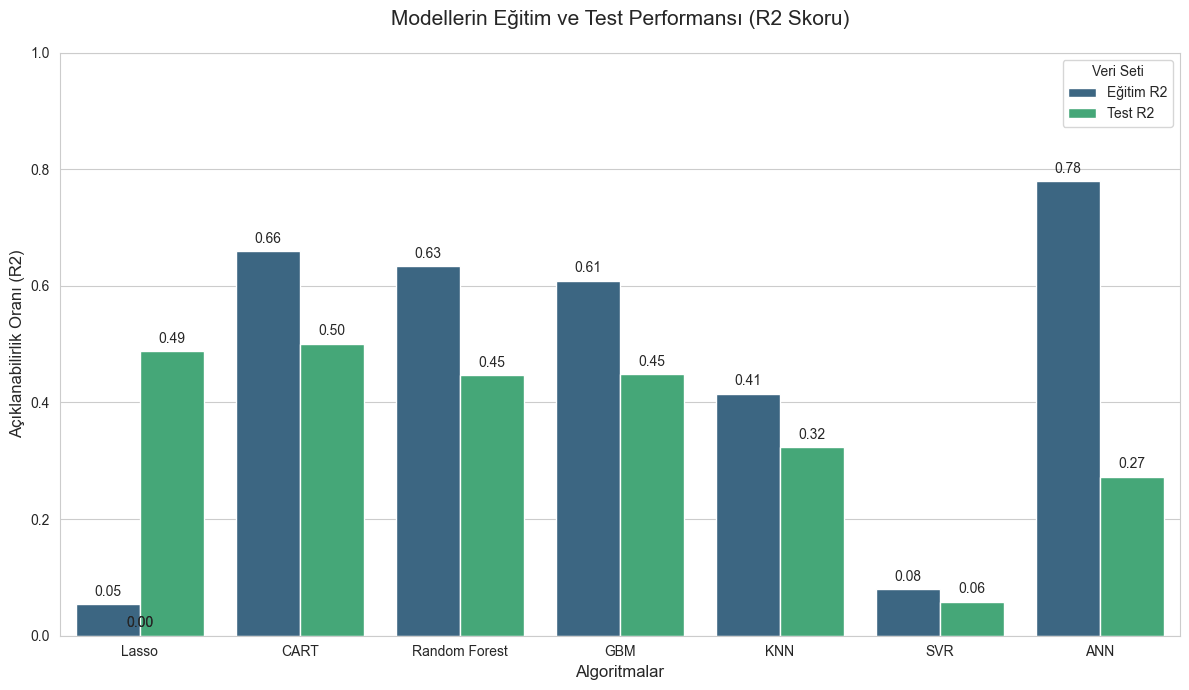

In [82]:
#GRAFİKSEL GÖSTERİMLER:
import seaborn as sns

data = {
    'Model': ['Lasso', 'CART', 'Random Forest', 'GBM', 'KNN', 'SVR', 'ANN'],
    'Eğitim R2': [0.0540, 0.6595, 0.6341, 0.6087, 0.4150, 0.0799, 0.7798],
    'Test R2': [0.4876, 0.5010, 0.4470, 0.4486, 0.3231, 0.0579, 0.2724]
}

df_plot = pd.DataFrame(data)
df_plot_melted = df_plot.melt(id_vars='Model', var_name='Veri Seti', value_name='R2 Skoru')

# Grafiği Çizdirme
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
barplot = sns.barplot(x='Model', y='R2 Skoru', hue='Veri Seti', data=df_plot_melted, palette='viridis')

plt.title('Modellerin Eğitim ve Test Performansı (R2 Skoru)', fontsize=15, pad=20)
plt.ylabel('Açıklanabilirlik Oranı (R2)', fontsize=12)
plt.xlabel('Algoritmalar', fontsize=12)
plt.ylim(0, 1.0) # 0 ile 1 arası ölçek
plt.legend(title='Veri Seti')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=10)

plt.tight_layout()
plt.show()

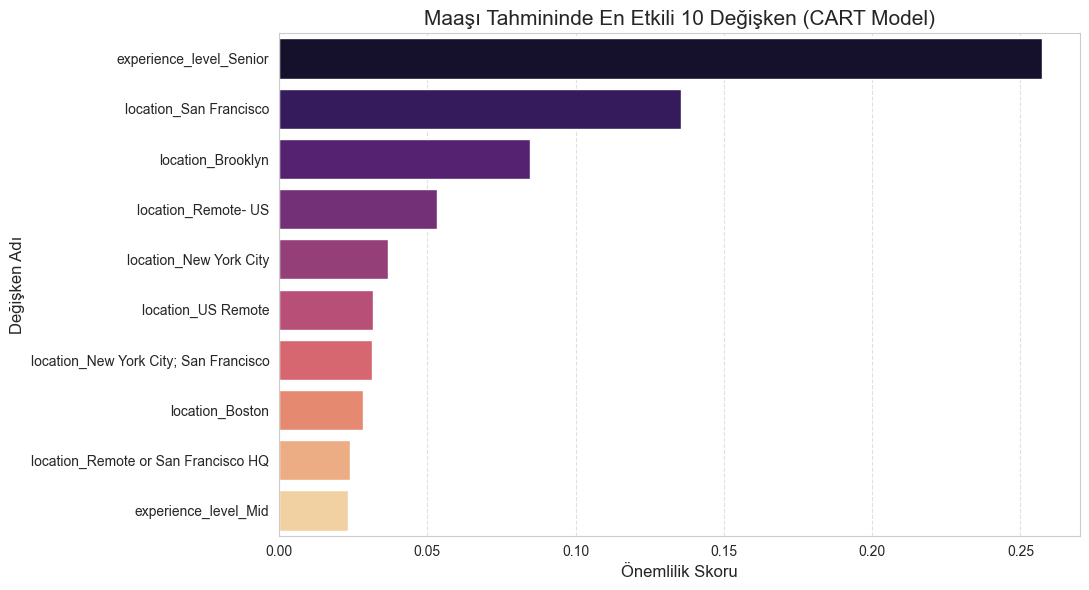

In [85]:
#DEĞİŞKEN ÖNEMLİLİĞİ GRAFİĞİ
# En iyi performans göstermiş olan CART modelimizdeki değişkenlerin önemliliğini inceleyelim.

# En önemli 10 değişkeni çekelim
feature_importance = pd.DataFrame({
    'Değişken': x_train.columns,
    'Önem Oranı': tunedcart.feature_importances_
}).sort_values(by='Önem Oranı', ascending=False).head(10)

plt.figure(figsize=(11, 6))
sns.barplot(x='Önem Oranı', y='Değişken', data=feature_importance, palette='magma')

plt.title('Maaşı Tahmininde En Etkili 10 Değişken (CART Model)', fontsize=15)
plt.xlabel('Önemlilik Skoru', fontsize=12)
plt.ylabel('Değişken Adı', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#YORUM:
#En Belirleyici Faktör: Kıdem (Seniority): Grafikteki en yüksek barın bir kıdem göstergesi) olması, 
#veri bilimi sektöründe maaşı belirleyen bir numaralı unsurun tecrübe yılı ve uzmanlık derecesi olduğunu kanıtlar.

#Coğrafi Konum Etkisi: Lokasyon bazlı değişkenlerin (özellikle ABD merkezli roller veya yaşam maliyeti yüksek şehirler) üst sıralarda 
#yer alması, şirketlerin maaş politikalarını bölgesel ekonomik şartlara göre şekillendirdiğini gösterir.

#Hiyerarşik Karar Yapısı: CART modeli, bu değişkenleri kullanarak veriyi dallara ayırmıştır. 
#Örneğin; "Eğer çalışan Senior ise ve ABD lokasyonundaysa maaş şu seviyededir" gibi net ve keskin kurallar üreterek tahminde bulunmuştur.